<a href="https://colab.research.google.com/github/arbirdi/IRC_Generative_Medical_imaging/blob/main/Rewritten_2_2_120x120_DCGAN_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:

see: https://www.tensorflow.org/tutorials/generative/dcgan

## Module Imports

In [ ]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs
!pip install PIL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-1buamo7_
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-1buamo7_
  Resolved https://github.com/tensorflow/docs to commit 393d7b6fa6aa68a8e01013582cbdb5c0fe4fde1c
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=182571 sha256=8f78a6630b00ae2b1d434fe7bad14c93c72298959e8e3a94d4dd3eac8edff067
  Stored in directory: /tmp/pip-ephem-wheel-cache-a_5br77_/wheels/fc/f8/3b/5d21409a59cb1be9b1ade11f682039ced75b84de9dd6a0c8de
Successfully built tensorflow-docs
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time
from IPython import display

## Tensorflow Setup

In [ ]:
tf.__version__

'2.11.0'

In [ ]:
"""physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)"""

'physical_devices = tf.config.list_physical_devices("GPU")\ntf.config.experimental.set_memory_growth(physical_devices[0], True)'

## Data Cleaning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/IRC

/content/drive/MyDrive/IRC


In [ ]:
#import data
train_images_original = np.load('2d_data.npy')
train_labels = np.load('2d_label.npy')

In [ ]:

#load data

(4455, 240, 240, 1)


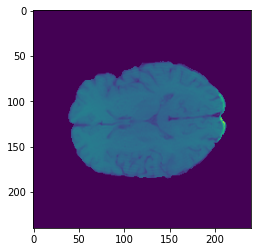

In [ ]:
#clean data
print(train_images_original.shape)
plt.imshow(train_images_original[0])

In [ ]:
from sklearn import preprocessing
import scipy as sp
import copy

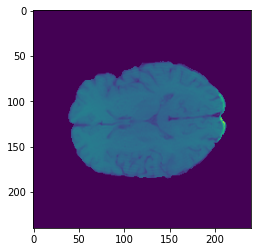

{'whiskers': [<matplotlib.lines.Line2D at 0x7f647af51160>,
 'caps': [<matplotlib.lines.Line2D at 0x7f647af2a430>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f647af51eb0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f647af2af40>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f647af2a370>],
 'means': []}

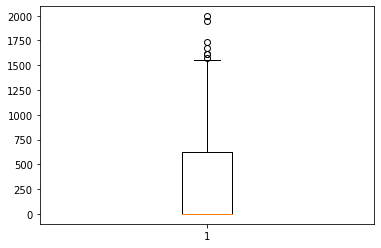

In [ ]:
plt.imshow(train_images_original[0].reshape(240,240))
plt.show()
plt.boxplot(train_images_original[0].flatten())

(array([3.9969e+04, 3.1000e+01, 6.6000e+01, 2.1000e+02, 5.7900e+02,
        1.5070e+03, 6.3430e+03, 7.7540e+03, 9.9700e+02, 3.6000e+01,
        2.1000e+01, 2.8000e+01, 3.2000e+01, 1.1000e+01, 5.0000e+00,
        5.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([   0.        ,   99.73698425,  199.47396851,  299.2109375 ,
         398.94793701,  498.68490601,  598.421875  ,  698.15887451,
         797.89587402,  897.6328125 ,  997.36981201, 1097.10681152,
        1196.84375   , 1296.58081055, 1396.31774902, 1496.0546875 ,
        1595.79174805, 1695.52868652, 1795.265625  , 1895.00268555,
        1994.73962402]),
 <BarContainer object of 20 artists>)

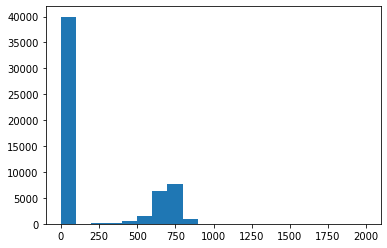

In [ ]:
plt.hist(train_images_original[0].flatten(), bins = 20)

In [ ]:
"""train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]"""

training_image = np.zeros(shape=(240,240))
resized_training_images = np.zeros(shape=(train_images_original.shape[0], 120,120, 1))#train_images.shape[1]/2, train_images.shape[2]/2, 1))
train_images = copy.deepcopy(train_images_original)
logit_lmbda = lambda x: np.log(x/(1-x)) #sp.special.logit(x)
logit_vfunc = np.vectorize(logit_lmbda)
a, b = (1/(1+np.exp(1))), 0.95
c=b-a
d, e = 0.5, 0.95
f = e-d
for i in range(train_images.shape[0]):
  train_images[i] = train_images[i]/max(train_images[i].flatten()) #normalise images to [0,1] - possibly in the future change this to [-1, 1]
  train_images[i] = (train_images[i]*(c)) + a #turn images to [0.05, 0.95]
  #train_images[i] = (train_images[i]*2)-1 #scaled to [-1,1]
  train_images[i] = np.log(train_images[i]/(1-train_images[i]))
  train_images[i] = (train_images[i] +1)/2
  training_image = train_images[i]
  training_image[training_image > 1] = 1
  train_images[i] = training_image
  """train_images[i] = (train_images[i]*(c)) + a
  train_images[i] = np.log(train_images[i]/(1-train_images[i]))
  training_image = train_images[i]
  training_image[training_image > 1] = 1
  train_images[i] = training_image
  train_images[i] = (train_images[i] +1)/2
  train_images[i] = (train_images[i]*(f)) + d
  train_images[i] = np.log(train_images[i]/(1-train_images[i]))
  train_images[i] = (train_images[i])/max(train_images[i].flatten())"""
  #train_images[i] = train_images[i]/max(train_images[i].flatten())
  #train_images[i] = (train_images[i]*(c))+a
  #train_images[i] = np.log(train_images[i]/(1-train_images[i]))
  #train_images[i] = logit_vfunc(train_images[i])
  #scaler = preprocessing.StandardScaler().fit(train_images[i].flatten().reshape(-1,1))
  #training_image = scaler.transform(train_images[i].flatten().reshape(-1,1)).reshape(240,240)
  #training_image = training_image.reshape(240,240,1)
  #training_image[training_image > 3] = 3
  #train_images[i] = scaler.transform(train_images[i].flatten).reshape(120,120,1)
  resized_training_images[i] = train_images[i,::2,::2,:]#training_image[::2,::2,:]

(array([3.9969e+04, 1.0000e+00, 1.7000e+01, 3.5000e+01, 6.8000e+01,
        1.5800e+02, 3.2900e+02, 6.1300e+02, 1.3090e+03, 4.0260e+03,
        7.3040e+03, 3.2750e+03, 3.5100e+02, 2.1000e+01, 2.7000e+01,
        1.3000e+01, 1.9000e+01, 2.1000e+01, 1.6000e+01, 2.8000e+01]),
 array([0.        , 0.05      , 0.1       , 0.15000001, 0.2       ,
        0.25      , 0.30000001, 0.34999999, 0.40000001, 0.44999999,
        0.5       , 0.55000001, 0.60000002, 0.64999998, 0.69999999,
        0.75      , 0.80000001, 0.85000002, 0.89999998, 0.94999999,
        1.        ]),
 <BarContainer object of 20 artists>)

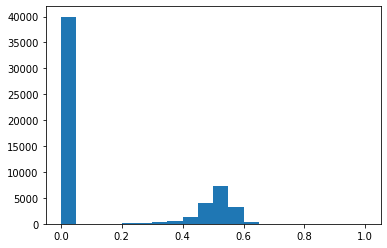

In [ ]:
plt.hist(train_images[0].flatten(), bins=20)

In [ ]:
"""print(list(set(train_images_original[0].flatten())))

min_scan_intensity = []
for el in train_images_original:
  min_scan_intensity.append(list(set(el.flatten()))[1])"""

'print(list(set(train_images_original[0].flatten())))\n\nmin_scan_intensity = []\nfor el in train_images_original:\n  min_scan_intensity.append(list(set(el.flatten()))[1])'

In [ ]:
#plt.hist(min_scan_intensity, bins =100)

In [ ]:
np.save('logit_brain_images_120', resized_training_images)

In [ ]:
resized_training_images[0]

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

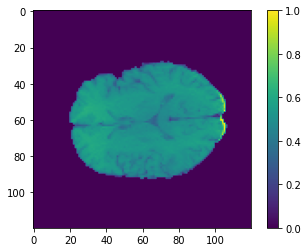

In [ ]:
#plt.imshow(train_images[0])
plt.imshow(resized_training_images[0])
plt.colorbar()
plt.show()

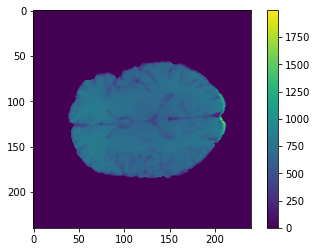

In [ ]:
plt.imshow(train_images_original[0])
plt.colorbar()
plt.show()

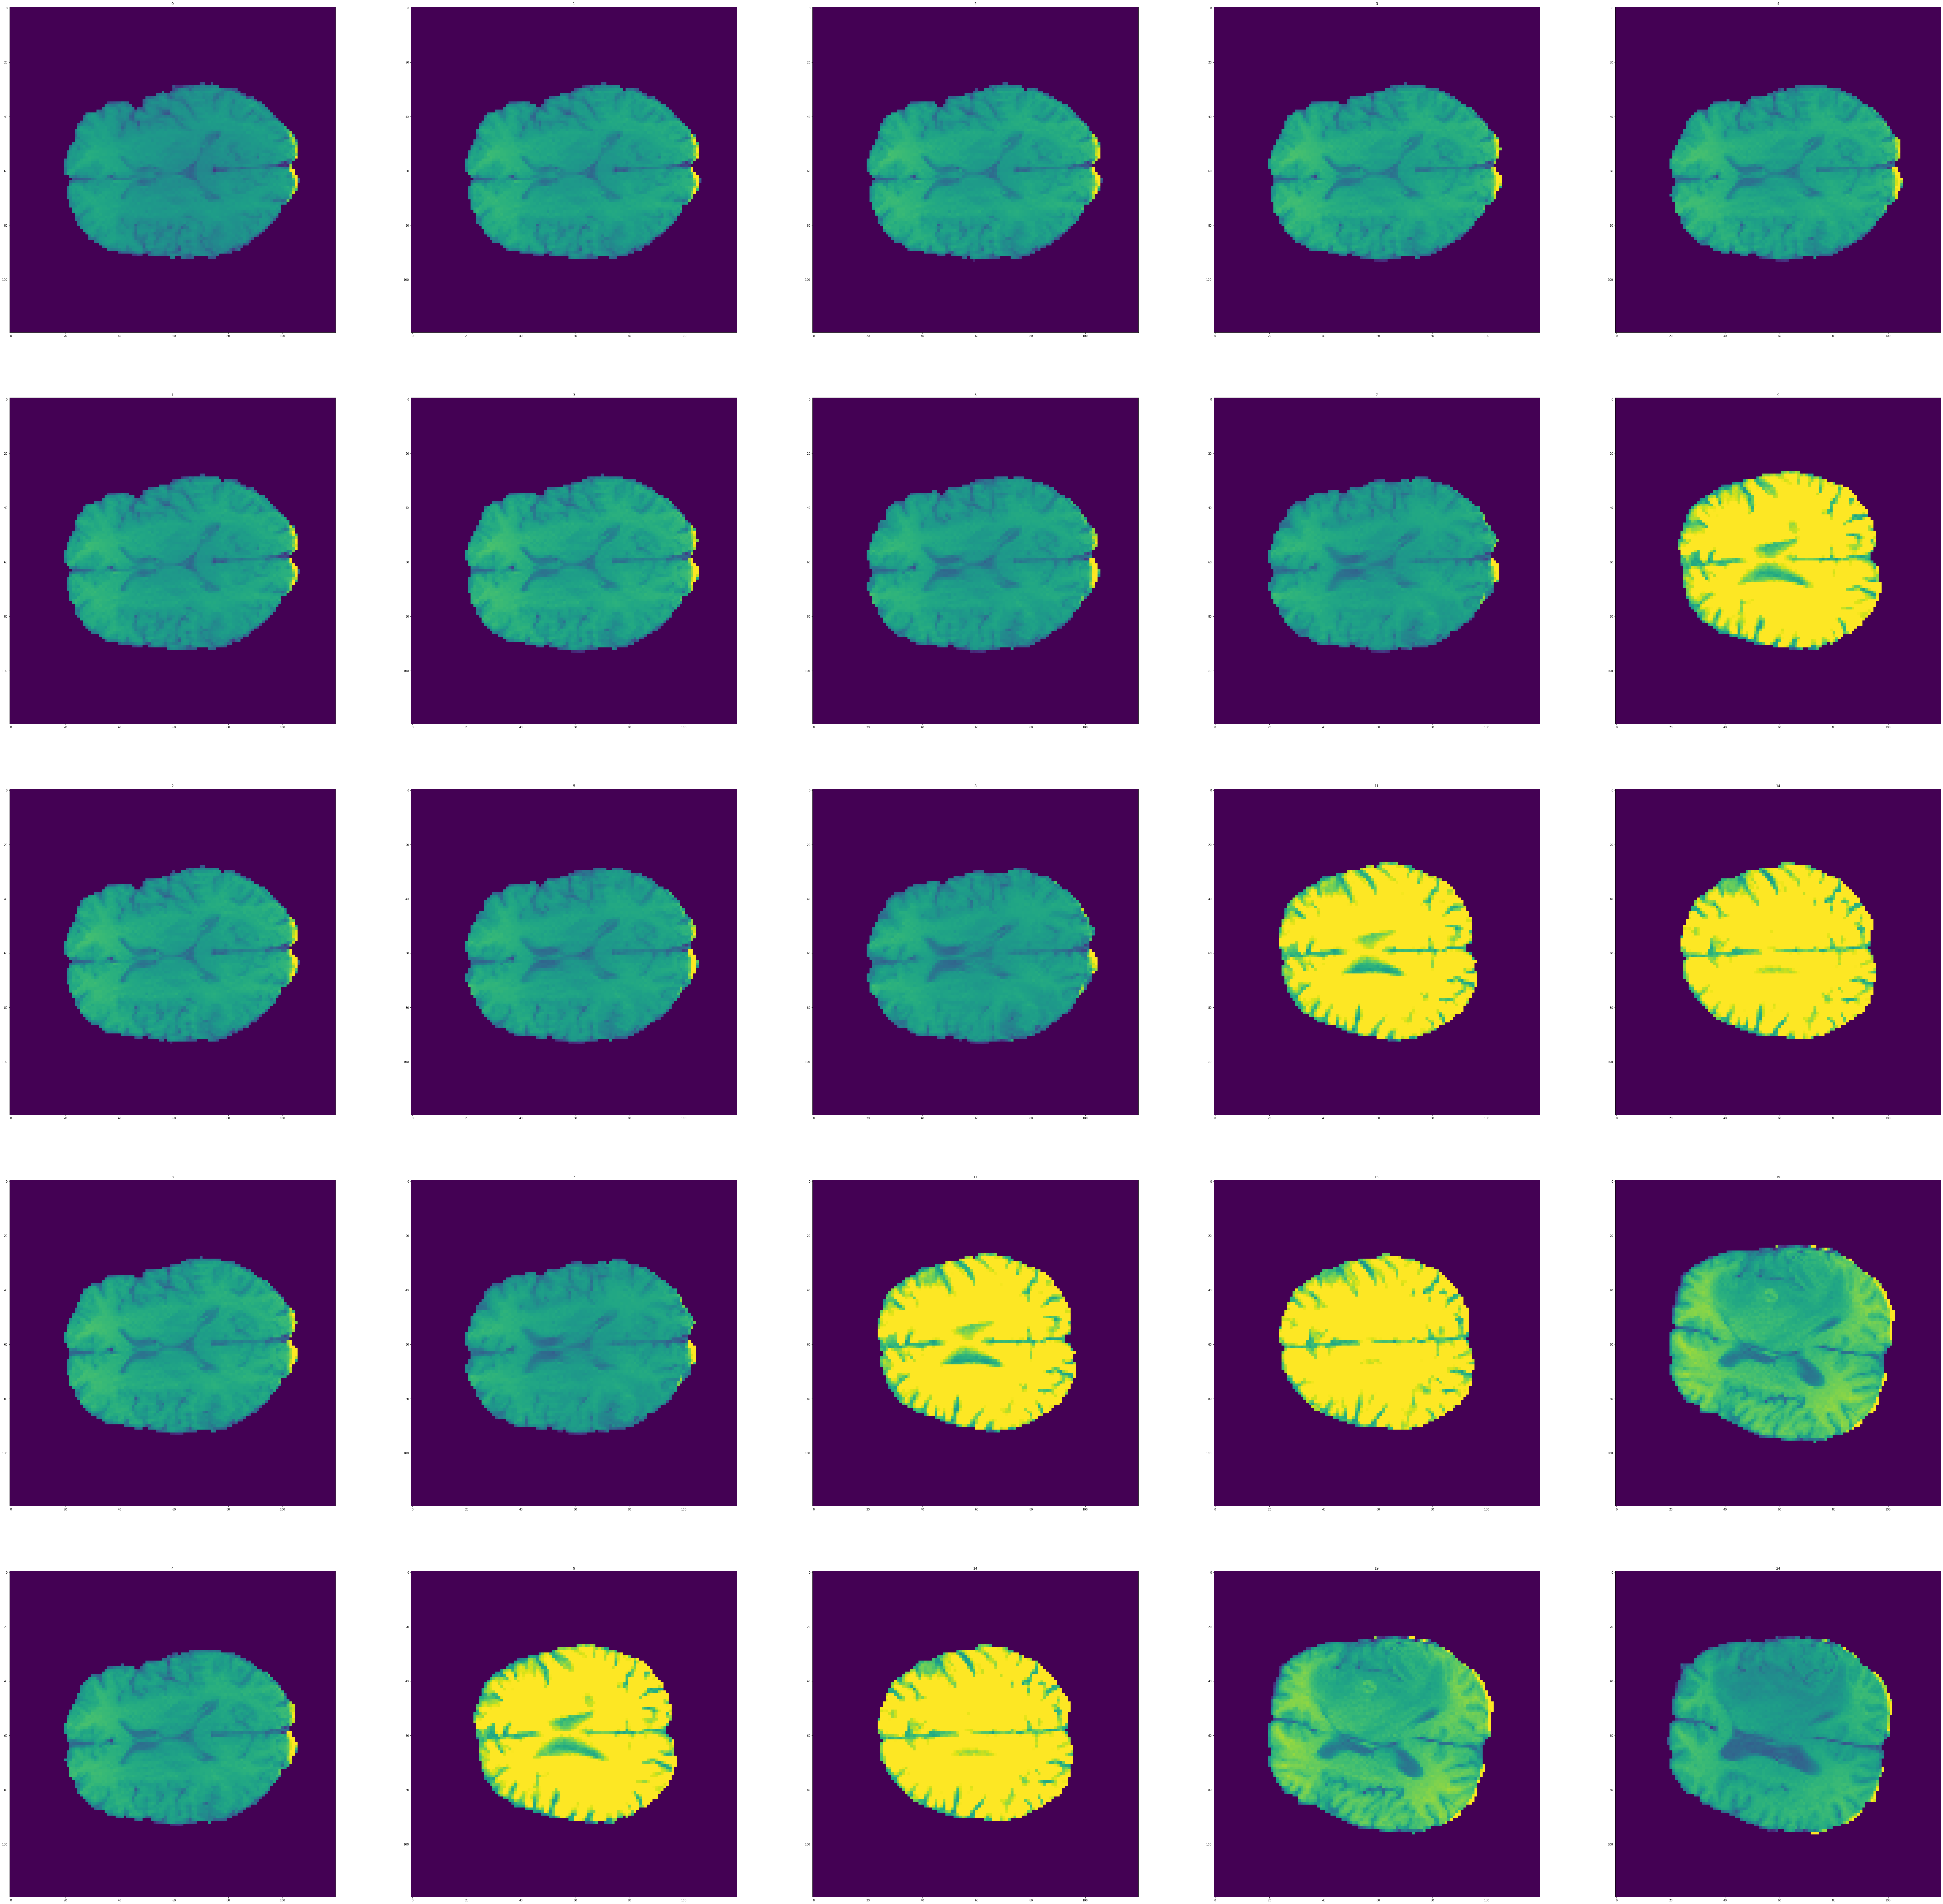

In [ ]:
#plt.#plt.imshow(resized_training_images[0])
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(120,120))
for r in range(5):
    for c in range(5):
        ax[r][c].imshow(resized_training_images[(r+1)*(c+1)-1])
        ax[r][c].title.set_text(f"{(r+1)*(c+1)-1}")
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f641f076160>,
 'caps': [<matplotlib.lines.Line2D at 0x7f641f076d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f641f07a280>],
 'medians': [<matplotlib.lines.Line2D at 0x7f641f076b80>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f647af2e790>],
 'means': []}

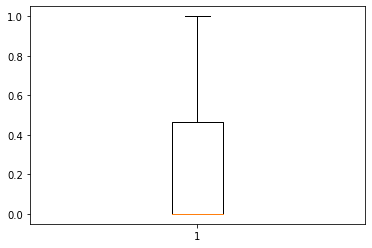

In [ ]:
plt.boxplot(train_images[0].flatten())

{'whiskers': [<matplotlib.lines.Line2D at 0x7f641ce0ed90>,
 'caps': [<matplotlib.lines.Line2D at 0x7f641ce1f310>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f641ce0eaf0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f641ce1f850>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f641ce1faf0>],
 'means': []}

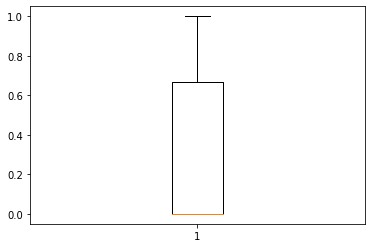

In [ ]:
plt.boxplot(resized_training_images[11].flatten())

{'whiskers': [<matplotlib.lines.Line2D at 0x7f641cd94130>,
 'caps': [<matplotlib.lines.Line2D at 0x7f641cd94550>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f641ce03e50>],
 'medians': [<matplotlib.lines.Line2D at 0x7f641cd94a90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f641cd94d30>],
 'means': []}

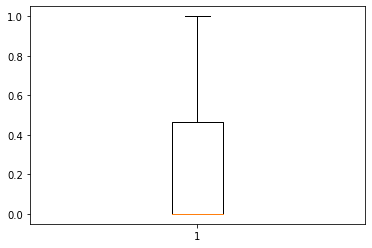

In [ ]:
plt.boxplot(resized_training_images[0].flatten())

In [ ]:
np.save('resized_training_images', resized_training_images)

In [ ]:
#batch and shuffle data

In [ ]:
BUFFER_SIZE = 4455
BATCH_SIZE = 200
train_dataset = tf.data.Dataset.from_tensor_slices(resized_training_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
print(train_dataset)

<BatchDataset element_spec=TensorSpec(shape=(None, 120, 120, 1), dtype=tf.float64, name=None)>


## The Generator

In [ ]:
latent_dim = 128
import time
def make_generator_model():
    model = tf.keras.Sequential(
        [
            layers.Input(shape=(latent_dim,)),
            layers.Dense(15*15*64),
            layers.Reshape((15,15,64)),
            layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(0.2),
            layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(0.2),
            layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(0.2),
            layers.Conv2DTranspose(1, kernel_size=5, padding="same", activation='sigmoid'),
        ]
    )
    return model

"""layers.Conv2DTranspose(256, kernel_size=4, strides=1, padding="same"),
            layers.LeakyReLU(0.2),
            layers.Conv2DTranspose(256, kernel_size=4, strides=1, padding="same"),
            layers.LeakyReLU(0.2),"""

make_generator_model().summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 14400)             1857600   
                                                                 
 reshape_2 (Reshape)         (None, 15, 15, 64)        0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 30, 30, 64)       65600     
 ranspose)                                                       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 30, 30, 64)        0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 60, 60, 128)      131200    
 ranspose)                                                       
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 60, 60, 128)      

In [ ]:

noise = tf.random.normal([1, 128])
print(noise)

tf.Tensor(
[[ 0.50033826  1.1146871  -1.7248863   0.04020155  1.0415591   0.24409273
  -1.5860074   1.3909312  -0.79257697 -2.5164962   0.50513923 -0.14004181
   0.01001338 -0.38563514  0.47635654  0.00818327  0.9805334  -0.01017592
  -0.7152285   0.13635874 -1.0087845  -0.23805448  0.42466795 -0.66294366
   0.14716819  0.53635204 -0.774295   -0.5001545  -1.1920452  -1.2736287
  -0.17002746  1.7009846  -0.70098937 -0.7824965  -0.8839028  -1.1461021
   0.00610333  0.5326267   0.7316587   0.4616005   0.11327215 -1.6157928
   0.31082162  0.40944064 -1.0790242   0.53580785  0.20630251  0.7622763
  -1.4017607   0.79735947 -0.9170996   1.622465    0.40051922 -0.7333913
   0.04065757  0.13970302  0.8818415  -0.40876815  1.1689597  -0.44377548
   0.1241151   1.7536309  -0.61518806  0.57089627  1.3056817  -0.90843034
   0.04834479 -0.07257435  0.93365246 -0.03317428  1.1055853  -0.6767314
   0.56367475  0.21437936 -0.176286    0.23060258 -0.11802951 -0.6745089
  -0.24121247 -1.2401794   0.81416

tf.Tensor(
[[ 8.2909024e-01  7.8967345e-01 -2.7224185e+00  2.7516434e-01
   1.8534498e+00 -1.4972615e+00 -7.8965026e-01  5.4944974e-01
   2.5058057e+00 -6.6658419e-01  1.5790424e+00 -1.1963640e+00
   1.4320650e+00 -1.3702281e+00  1.3796045e-01 -5.2296788e-01
  -1.0558220e+00  4.2593598e-01 -2.9834172e-01  1.0674607e+00
  -2.6501235e-01  5.8104545e-01  1.5503978e+00 -7.3521592e-02
  -8.7391180e-01 -1.1816525e+00 -1.3120304e+00 -6.8876737e-01
  -6.5261950e-03 -2.6287752e-01  1.6336303e+00  1.6130689e+00
  -2.0195136e+00  9.7672015e-01  7.3608804e-01  2.0048970e-02
  -1.9021822e+00  1.1241021e+00 -3.9483777e-01 -6.7773825e-01
  -9.2230856e-01 -7.4974412e-01  1.0502411e-01  9.5064127e-01
   2.5161245e-01  1.3265131e-01  1.5167915e+00  1.1658213e+00
  -5.2653289e-01 -2.1539450e+00 -2.7249177e+00 -6.3536859e-01
  -1.4664765e-01  3.4999317e-01  7.5694299e-01 -1.1476903e+00
   6.4111596e-01  2.3418424e+00  2.4458702e-01  5.6790990e-01
   8.6761659e-01 -3.1556451e-01  3.7474751e-01 -5.0505841e-

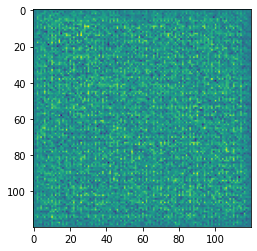

In [ ]:
#Creating an image using the untrained generator
generator = make_generator_model()

noise = tf.random.normal([1, 128])
generated_image = generator(noise, training=False)
print(noise)

plt.imshow(generated_image[0, :, :, 0])

## The Discriminator

In [ ]:
"""def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model"""

def make_discriminator_model():
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(120,120,1)),
            layers.Conv2D(60, kernel_size=4, strides=2, padding='same'),
            layers.LeakyReLU(0.2),
            layers.Conv2D(120, kernel_size=4, strides=2, padding='same'),
            layers.LeakyReLU(0.2),
            layers.Conv2D(120, kernel_size=4, strides=2, padding='same'),
            layers.LeakyReLU(0.2),
            layers.Conv2D(120, kernel_size=4, strides=2, padding='same'),
            layers.LeakyReLU(0.2),
            layers.Flatten(),
            layers.Dropout(0.2),
            layers.Dense(1, activation='sigmoid'),
        ]
    )
    return model

make_discriminator_model().summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 60, 60, 60)        1020      
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 60, 60, 60)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 30, 120)       115320    
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 30, 30, 120)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 15, 15, 120)       230520    
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 15, 15, 120)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 120)        

In [ ]:
#Using the untrained discriminator to classify the untrained generated image
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.50116986]], shape=(1, 1), dtype=float32)


## Losses and Optimisers - Generator and Discriminator


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(5e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

## Checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training Loop

In [ ]:
EPOCHS = 50
noise_dim = 128
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
discriminator_losses = []
generator_losses = []

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      generator_losses.append(gen_loss) #added!
      disc_loss = discriminator_loss(real_output, fake_output)
      discriminator_losses.append(disc_loss) #added!

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    print(time.strftime("%H:%M:%S", time.localtime()))

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec at {}'.format(epoch + 1, time.time()-start, time.strftime("%H:%M:%S", time.localtime())))
    

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10, 10))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  #plt.savefig('image_at_epoch_{:04d}_at_{time.strftime("%H:%M:%S", time.localtime())}.png'.format(epoch))
  plt.show()

In [ ]:
"""#Restores last checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))"""

'#Restores last checkpoint\ncheckpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))'

## Training the Model

In [ ]:
import time

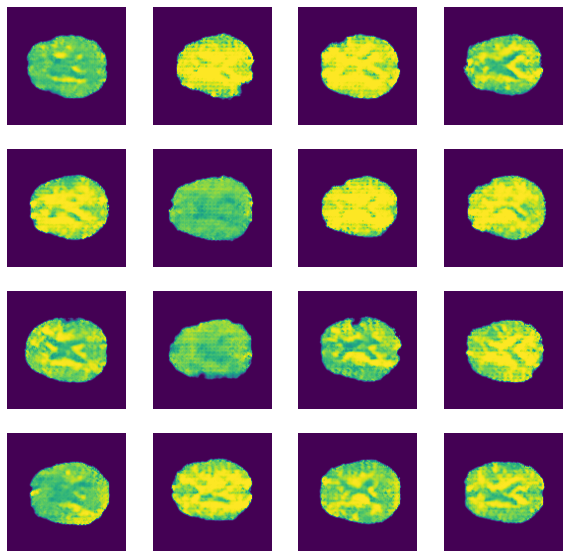

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
generator.save(f'generator_18_03_23_600_epoch_half_learning_rate_2.h5')
#.save()


## Displaying Images

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

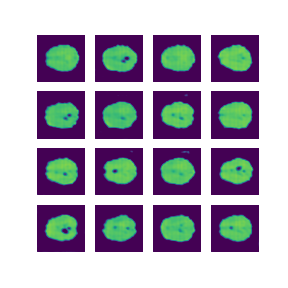

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
predict_image = generator.predict(tf.random.normal([100, 128]))
generator.save(f'generator_save_50_epoch_{time.strftime("%H:%M:%S", time.localtime())}')

4/4 [==============================] - 0s 6ms/step


In [ ]:
np.save(f'predicted_images_{time.strftime("%H:%M:%S", time.localtime())}', predict_image)

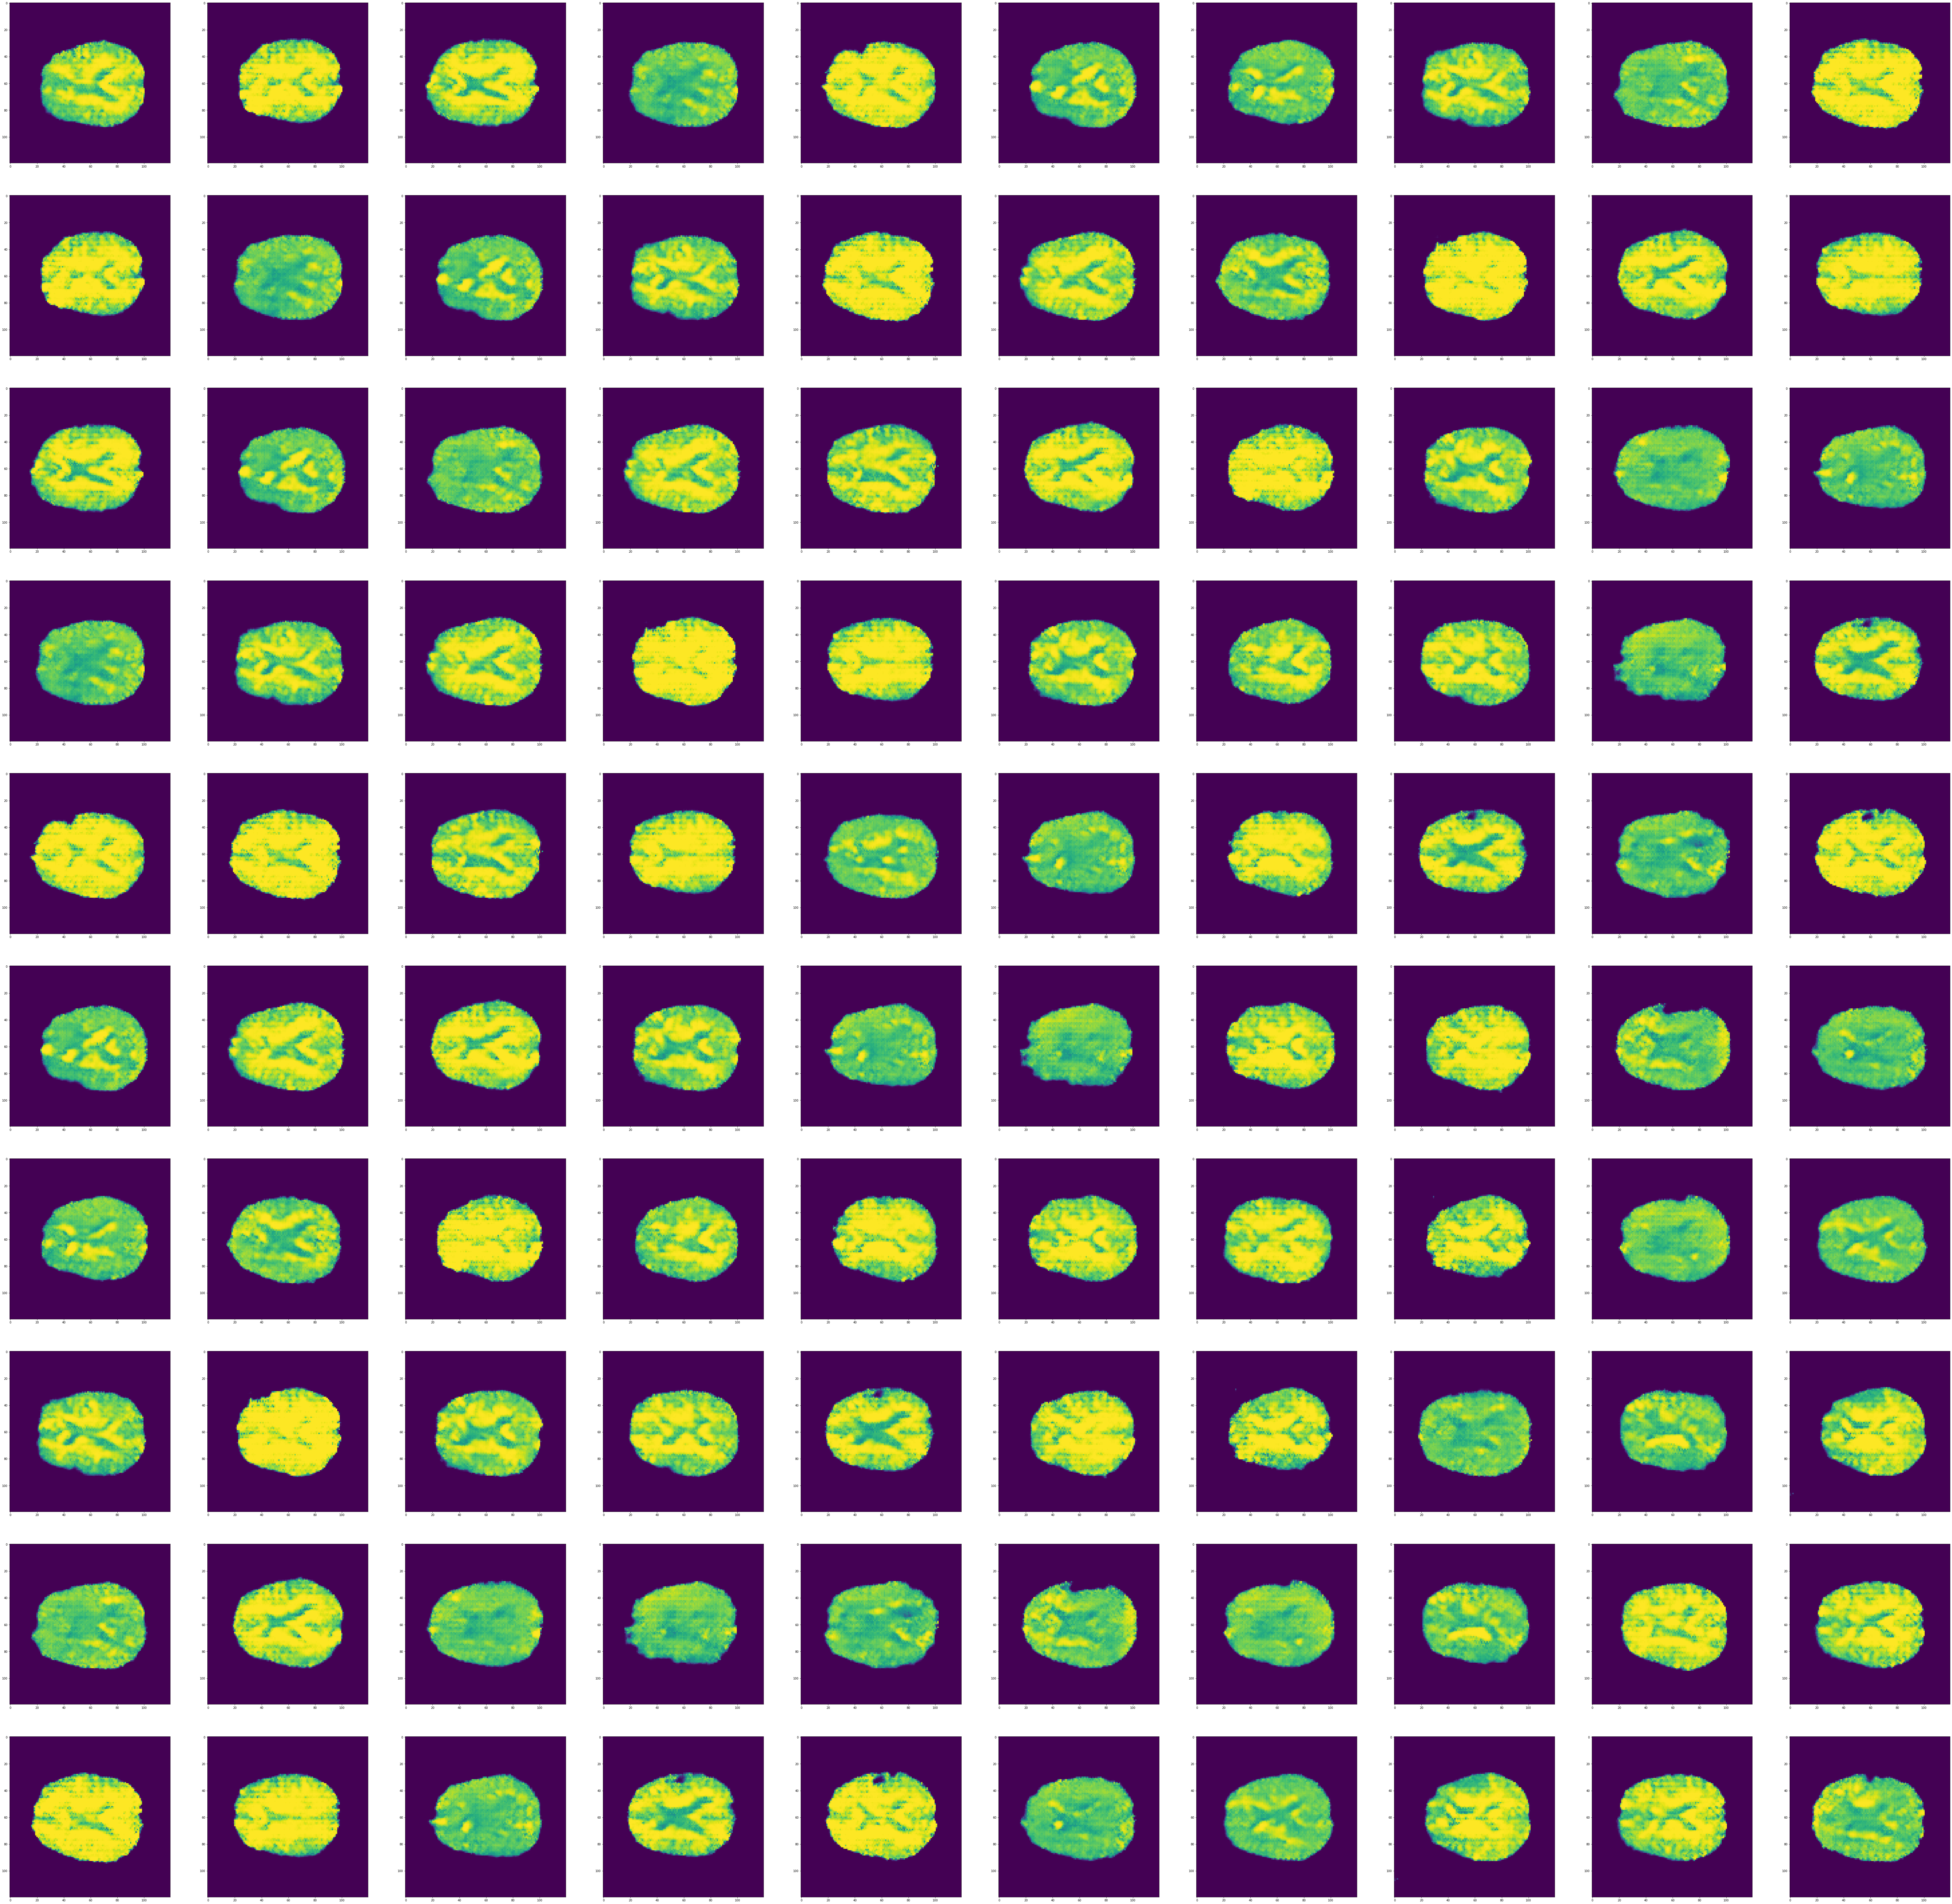

In [ ]:
fig, ax = plt.subplots(ncols=10, nrows=10, figsize=(120,120))
for r in range(10):
    for c in range(10):
        ax[r][c].imshow(predict_image[(r+1)*(c+1)-1])
image_number = time.strftime("%H:%M:%S", time.localtime())
plt.savefig(f"brain_image_predictions_17_03_2023_{image_number}.svg")
plt.savefig(f"brain_image_predictions_17_03_2023_{image_number}.png")
plt.show()

In [ ]:
large_predict_image = generator.predict(tf.random.normal([10000, 128]))
np.save(f'large_predicted_images_{time.strftime("%H:%M:%S", time.localtime())}', predict_image)

313/313 [==============================] - 2s 6ms/step
